DATA PREPROCESSING

In [1]:
import os
import pandas as pd
import ipaddress
from PIL import Image
import matplotlib.pyplot as plt
from configurations import binary_lable
from utils import has_digit, remove_digits, remove_suffix, classifi_by_rules, decimal_to_256, nearest_square
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from configurations import traffic_rules
import math
from imblearn.over_sampling import ADASYN
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Thư mục chứa các file dataset đã transfer
dataset_folder = "new_transfered_dataset"
# Thư mục chức các file csv đã gán nhãn
classified_folder = "classified_dataset"
files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

Preprocessing 1. Đọc Dataset, gán nhãn, merge CSV files

In [8]:
print("##### START READING DATASET ######")
dataframes = []
file_indx = 1
flow_counter = {}
for file in files:
    file_path = os.path.join(dataset_folder, file)
    df = pd.read_csv(file_path)

    # Format tên các cột
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    file_name = file.split(".")[0]

    # Bỏ cột flow_id, timestamp
    df = df.drop('flow_id', axis=1)
    df = df.drop('timestamp', axis=1)

    # Chuyển hóa các địa chỉ IP thành int
    for index, row in df.iterrows():
        int_src_ip = int(ipaddress.ip_address(df.iloc[index]["src_ip"]))
        int_dst_ip = int(ipaddress.ip_address(df.iloc[index]["dst_ip"]))
        df.at[index, 'src_ip'] = int_src_ip
        df.at[index, 'dst_ip'] = int_dst_ip

    # Gán nhãn các row
    processed_name = remove_suffix(file_name)
    label = classifi_by_rules(traffic_rules, processed_name)
    file_indx = file_indx + 1
    if(label is not None):
        label_value = label[1]
        df["label"] = label_value
        dataframes.append(df) 
# # Lưu file
merged_df = pd.concat(dataframes, ignore_index=True)
merged_file_path = os.path.join(classified_folder, "traffics_dataset.csv")
merged_df.to_csv(merged_file_path, index=False)

print("##### READ DATASET DONE ######")

##### START READING DATASET ######
##### READ DATASET DONE ######


Preprocess 2. Áp dụng MinMaxScaler

In [9]:
print("##### START ENCODING DATASET ######")

traffics = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
selected_columns = traffics.columns

traffics[selected_columns] = traffics[selected_columns].replace([np.inf, -np.inf], np.nan)
traffics[selected_columns] = traffics[selected_columns].fillna(traffics[selected_columns].max())

# # Loại bỏ label
selected_columns = [item for item in selected_columns if item != "label"]
# # Khởi tạo Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 255))
# # Áp dụng Min-Max Scaler
traffics[selected_columns] = scaler.fit_transform(
    traffics[selected_columns])
traffics.to_csv(merged_file_path, index=False)

print("##### ENCODING DONE ######")

##### START ENCODING DATASET ######
##### ENCODING DONE ######


Preprocess 3. Áp dụng ADASYN resampling

##### START RESAMPLING WITH ADASYN ######


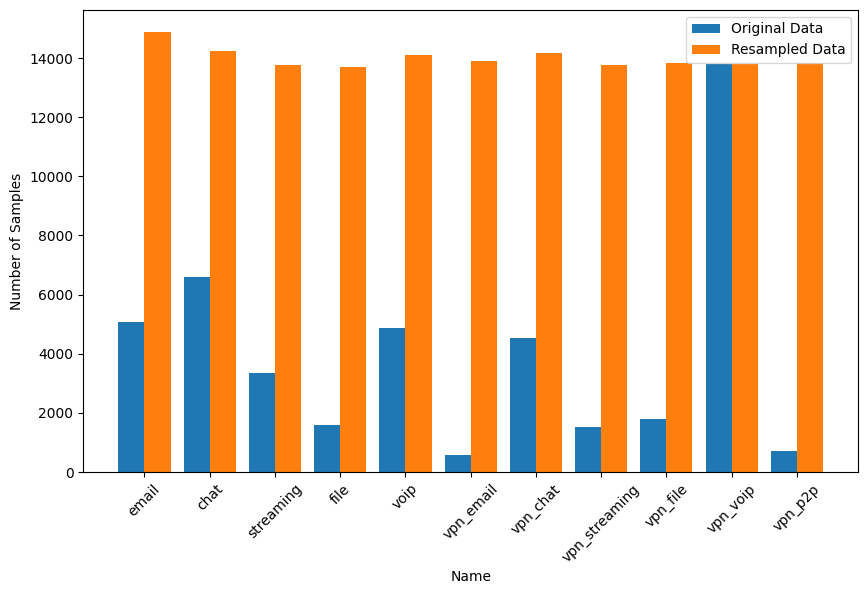

##### RESAMPLING WITH ADASYN DONE ######


In [10]:
print("##### START RESAMPLING WITH ADASYN ######")

data = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
original_class_distribution = data['label'].value_counts()

data.fillna(0, inplace=True)
X = data.drop('label', axis=1)  # Tập dữ liệu đầu vào
y = data['label']  # Nhãn
adasyn = ADASYN(sampling_strategy='not majority', random_state=42,
                n_neighbors=500)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data = pd.concat(
    [resampled_data, pd.DataFrame(y_resampled, columns=['label'])], axis=1)
resampled_class_distribution = resampled_data['label'].value_counts()
balanced_file_path = os.path.join(classified_folder, "traffics_dataset_balanced.csv")

combined_data = pd.concat([original_class_distribution, resampled_class_distribution], axis=1)
combined_data.columns = ['Original Data', 'Resampled Data']
combined_data = combined_data.sort_index()

class_labels = combined_data.index

label_to_name = {rule['label']: rule['name'] for rule in traffic_rules}
class_labels_mapped = [label_to_name[label] for label in class_labels]

plt.figure(figsize=(10, 6))
width = 0.4

plt.bar(range(len(class_labels_mapped)), combined_data['Original Data'], width=0.4, label='Original Data')
plt.bar([x + width for x in range(len(class_labels_mapped))], combined_data['Resampled Data'], width=0.4, label='Resampled Data')

plt.xlabel('Name')
plt.ylabel('Number of Samples')
plt.xticks([x + width/2 for x in range(len(class_labels_mapped))], class_labels_mapped, rotation=45)  # Set the x-ticks to be class names
plt.legend()
plt.show()

print("##### RESAMPLING WITH ADASYN DONE ######")
resampled_data.to_csv(balanced_file_path, index=False)

Preprocess 4. Fill các dữ liệu còn thiếu bằng 0

In [11]:
print("##### START ADDING ZEROS TO DATASET ######")

df = pd.read_csv(f'{classified_folder}/traffics_dataset_balanced.csv')
img_shape = nearest_square(df.shape[1]) + 1
num_new_columns = img_shape - df.shape[1]

for i in range(1, num_new_columns + 1):
    new_col_name = f'zeros_{i}'
    df.insert(df.shape[1] - 1, new_col_name, 0)
df.to_csv(merged_file_path, index=False)
print("Dataset's shape", df.shape)

print("##### ADD ZEROS TO DATASET DONE ######")

##### START ADDING ZEROS TO DATASET ######
Dataset's shape (154052, 82)
##### ADD ZEROS TO DATASET DONE ######


Preprocess 5. Chuyển từng dòng dữ liệu thành Image

In [4]:
print("##### START CREATTING IMAGES ######")

df = pd.read_csv(f'{classified_folder}/traffics_dataset.csv')
img_shape = nearest_square(df.shape[1]) + 1
data_img_shape = int(math.sqrt(img_shape-1))
for index, row in df.iterrows():
    data_row = df.iloc[index]
    label = data_row['label']
    data_row = data_row.drop('label')

    data_array = data_row.values.reshape(data_img_shape, data_img_shape)
    # Tạo hình ảnh từ mảng numpy
    image = Image.fromarray((data_array).astype('uint8'))

    output_folder = ""
    row_label = row["label"]
    for rule in traffic_rules:
        if rule["label"] == row_label:
            output_folder = rule["name"]
            
    output_folder_path = os.path.join(
        f'image_dataset/traffics_dataset/{output_folder}')
    # Tạo đường dẫn đầy đủ đến thư mục đích -> lưu
    output_path = os.path.join(
        f'image_dataset/traffics_dataset/{output_folder}', f'{index + 2}.png')
    
    # Kiểm tra nếu thư mục đích chưa tồn tại, thì tạo thư mục
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    image.save(output_path)

print("##### CONVERT TO IMAGE DONE. ######")

##### START CREATTING IMAGES ######
##### CONVERT TO IMAGE DONE. ######


MODEL TRAINING

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import torch.utils.data as data
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

Định nghĩa model

In [3]:
# Định nghĩa mô hình CNN
class CNNTrafficClassifier(nn.Module):
    def __init__(self, num_classes=11):
        super(CNNTrafficClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32) 
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32) 
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 2 * 2, 128) 
        self.relu5 = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)

        x = self.dropout(x)

        x = self.fc2(x)
        return x


model = CNNTrafficClassifier()

Chuẩn hóa dataset

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Resize((9, 9)),
    transforms.Grayscale(),    # Chuyển đổi thành ảnh xám
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [5]:
dataset_root = "image_dataset/traffics_dataset"  # Thư mục gốc chứa dataset
dataset = datasets.ImageFolder(
    root=dataset_root, transform=data_transform)

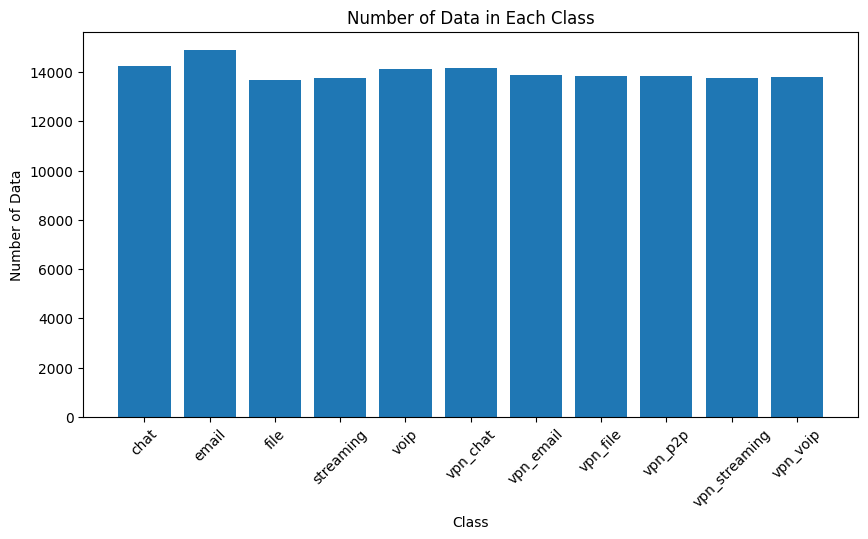

In [6]:
class_names_title = dataset.classes

class_sample_counts = {}
for label in class_names_title:
    # Đường dẫn tới thư mục của lớp
    class_dir = os.path.join(dataset_root, label)
    count = len([f for f in os.listdir(class_dir) if f.endswith('.png')])
    class_sample_counts[label] = count

plt.figure(figsize=(10, 5))
plt.bar(class_sample_counts.keys(), [
        count for count in class_sample_counts.values()])
plt.xlabel("Class")
plt.ylabel("Number of Data")
plt.title("Number of Data in Each Class")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Chia Train/Validate/Test tỉ lệ 70 - 15 - 15
batch_size = 258  # Kích thước batch
total_samples = len(dataset)

# Chia lượng data được sử dụng
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Lấy datata random theo tỉ lệ
selected_samples = random.sample(range(total_samples), samples_to_use)

# Tạo ra các subset trên mỗi sample
dataset = data.Subset(dataset, selected_samples)
total_samples = len(dataset)

train_size = int((0.7 * total_samples))
validate_size = int((0.15 * total_samples))
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)


Total 154052
Test Amount 23109
Train Amount 107836
Validation Amount 23107


In [8]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    current_gpu = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Have {gpu_count} GPU available.")
    print(f"GPU's name: {gpu_name}")
else:
    print("No GPU available.")
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Have 1 GPU available.
GPU's name: NVIDIA GeForce GTX 1050
11.7


In [9]:
num_epochs = 200  # Số lượng epoch
learning_rate = 0.0001

In [10]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
best_accuracy = 0.0  # Giá trị accuracy tốt nhất
patience = 10  # Số epoch không giảm loss cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện
weight_decay = 0.001

Train model

In [21]:
if torch.cuda.is_available():
    # Chuyển mô hình và dữ liệu lên GPU
    model = model.to(device)

    # Tạo hàm mất mát và tối ưu hóa trên GPU
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
        train_loss = 0
        correct_predictions = 0
        total_samples = 0
        model.train()
        # Lặp qua từng batch trong dữ liệu
        for images, labels in train_loader:  # train_dataloader chứa dữ liệu huấn luyện
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Feed-forward
            loss = criterion(outputs, labels)  # Tính hàm mất mát
            
            optimizer.zero_grad()  # Xóa gradient
            loss.backward()  # Lan truyền ngược để tính gradient
            optimizer.step()  # Cập nhật trọng số mô hình
            train_loss += loss.item() # Cost
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        train_accuracy = correct_predictions / total_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss/len(train_loader)) #Lost: Trung bình cộng các Cost

        # Đánh giá trên tập validate
        validate_loss = 0
        validate_correct_predictions = 0
        validate_total_samples = 0

        model.eval()  # Chuyển sang chế độ đánh giá

        for i, (images, labels) in enumerate(validate_loader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # Không tính đạo hàm trong quá trình đánh giá
                outputs = model(images)
                loss = criterion(outputs, labels)  # Tính hàm mất mát
                validate_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                validate_total_samples += labels.size(0)
                validate_correct_predictions += (predicted ==
                                                 labels).sum().item()

        validate_accuracy = validate_correct_predictions / validate_total_samples
        validate_accuracy_list.append(validate_accuracy)
        validate_loss_list.append(validate_loss/len(validate_loader))

        print(
            f"Training loss={train_loss_list[-1]}, Training Accuracy={train_accuracy * 100:.2f}%, "
            f"Validation loss={validate_loss_list[-1]}, Validation Accuracy={validate_accuracy * 100:.2f}%")

        if validate_loss_list[-1] >= best_loss:
            no_improvement_count += 1
        else:
            best_loss = validate_loss_list[-1]
            no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/200: Training loss=1.7447443578802226, Training Accuracy=40.42%, Validation loss=1.2058389359050328, Validation Accuracy=58.04%
Epoch 2/200: Training loss=1.1756450250103143, Training Accuracy=57.54%, Validation loss=0.9721517258220249, Validation Accuracy=63.18%
Epoch 3/200: Training loss=1.0154177717614972, Training Accuracy=62.12%, Validation loss=0.8763835165235732, Validation Accuracy=65.64%
Epoch 4/200: Training loss=0.9303742517409712, Training Accuracy=64.58%, Validation loss=0.8165941370858086, Validation Accuracy=67.65%
Epoch 5/200: Training loss=0.8737600679602919, Training Accuracy=66.27%, Validation loss=0.7790293859110938, Validation Accuracy=68.98%
Epoch 6/200: Training loss=0.8347761171856566, Training Accuracy=67.37%, Validation loss=0.7481275068389045, Validation Accuracy=69.62%
Epoch 7/200: Training loss=0.8052782094079342, Training Accuracy=68.39%, Validation loss=0.7263255390856002, Validation Accuracy=70.42%
Epoch 8/200: Training loss=0.7820899244130514, T

Lưu model checkpoint

In [22]:
model_save_path = "GUI/models/traffics_classification.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification.pth


Load model checkpoint

In [11]:
model_save_path = "GUI/models/traffics_classification.pth"
# Load lại model
model = CNNTrafficClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Dự đoán trên tập Test

In [12]:
model.eval()  # Chuyển mô hình sang chế độ đánh giá
correct_predictions = 0
total_samples = 0
all_predictions = []
all_labels = []

# Khởi tạo danh sách để lưu trữ xác suất dự đoán cho từng lớp
all_probs = []

with torch.no_grad():  # Tắt tính toán gradient trong quá trình đánh giá
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Feed-forward
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct_predictions / total_samples
all_probs = np.array(all_probs)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

label_to_class_name = {index: class_name for index,
                       class_name in enumerate(class_names_title)}
label_display = [label_to_class_name[label]
                 for label in range(len(class_names_title))]

for label, class_name in enumerate(label_display):
    print(f"Label {label}: {class_name}")

Test Accuracy: 80.52%
Label 0: chat
Label 1: email
Label 2: file
Label 3: streaming
Label 4: voip
Label 5: vpn_chat
Label 6: vpn_email
Label 7: vpn_file
Label 8: vpn_p2p
Label 9: vpn_streaming
Label 10: vpn_voip


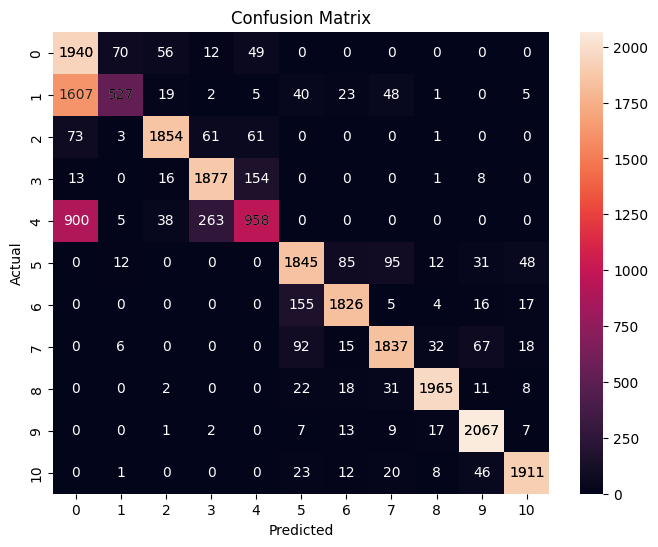

In [13]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

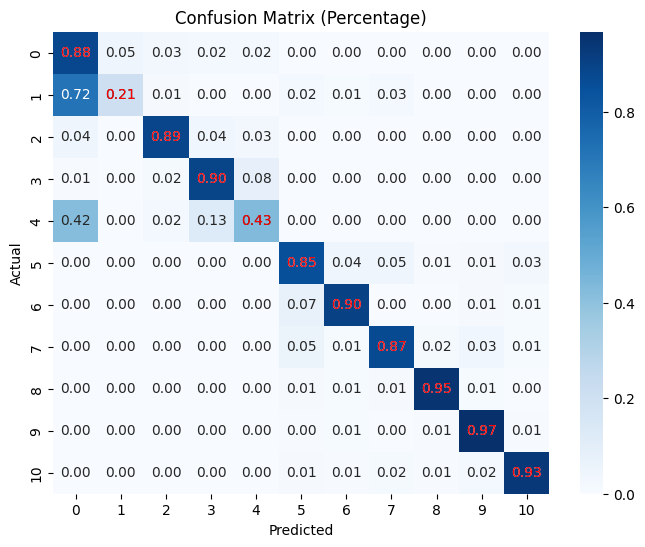

In [26]:
# Tính confusion matrix theo tỉ số
cm = confusion_matrix(all_labels, all_predictions)

# Chuyển ma trận nhầm lẫn sang dạng phần trăm
# Chia mỗi hàng cho tổng của hàng đó
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# In ra confusion matrix dưới dạng phần trăm
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5,
             f"{cm[i, i] / sum(cm[i, :]):.2f}", ha="center", va="center", color="red")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

Phân tích trên đồ thị

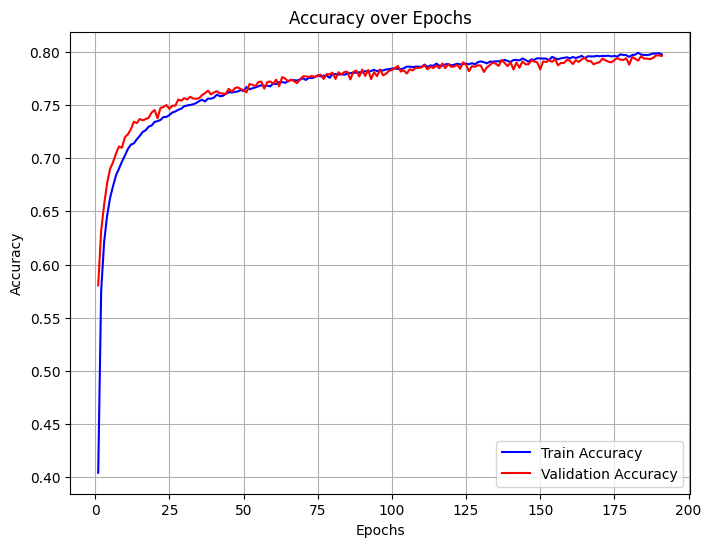

In [14]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

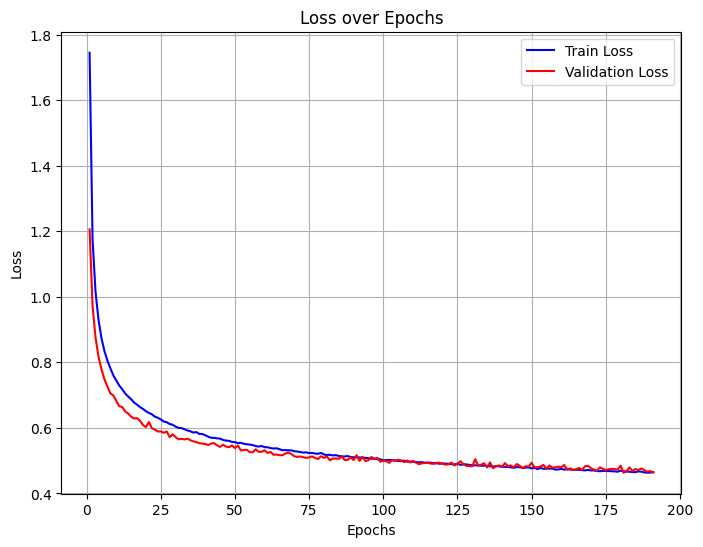

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Đánh giá model theo từng đại lượng

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd

In [17]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

accuracies = []
for label in range(len(class_names_title)):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    label_predictions = [all_predictions[i] for i in indices]
    label_true = [all_labels[i] for i in indices]
    accuracy = accuracy_score(label_true, label_predictions)
    accuracies.append(accuracy)

data = {'Class': label_display, 'Precision': precisions,
        'Recall': recalls, 'F1-Score': f1_scores, 'Accuracy': accuracies}
df = pd.DataFrame(data)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(df)
print("Model's precision", average_precision)
print("Model's recall", average_recall)
print("Model's f1-score",average_f1_score)
print(f"Model's Accuracy: {test_accuracy}%")

            Class  Precision    Recall  F1-Score  Accuracy
0            chat   0.427973  0.912083  0.582583  0.912083
1           email   0.844551  0.231445  0.363323  0.231445
2            file   0.933535  0.903069  0.918049  0.903069
3       streaming   0.846640  0.907202  0.875875  0.907202
4            voip   0.780766  0.442699  0.565025  0.442699
5        vpn_chat   0.844780  0.867011  0.855751  0.867011
6       vpn_email   0.916667  0.902620  0.909589  0.902620
7        vpn_file   0.898289  0.888728  0.893482  0.888728
8         vpn_p2p   0.962763  0.955275  0.959004  0.955275
9   vpn_streaming   0.920303  0.973622  0.946212  0.973622
10       vpn_voip   0.948858  0.945571  0.947212  0.945571
Model's precision 0.8477385336677579
Model's recall 0.8117567036400852
Model's f1-score 0.8014641603325
Model's Accuracy: 0.8051841273962526%


AUC for chat: 0.94
AUC for email: 0.95
AUC for file: 0.99
AUC for streaming: 0.99
AUC for voip: 0.95
AUC for vpn_chat: 0.99
AUC for vpn_email: 1.00
AUC for vpn_file: 0.99
AUC for vpn_p2p: 1.00
AUC for vpn_streaming: 1.00
AUC for vpn_voip: 1.00


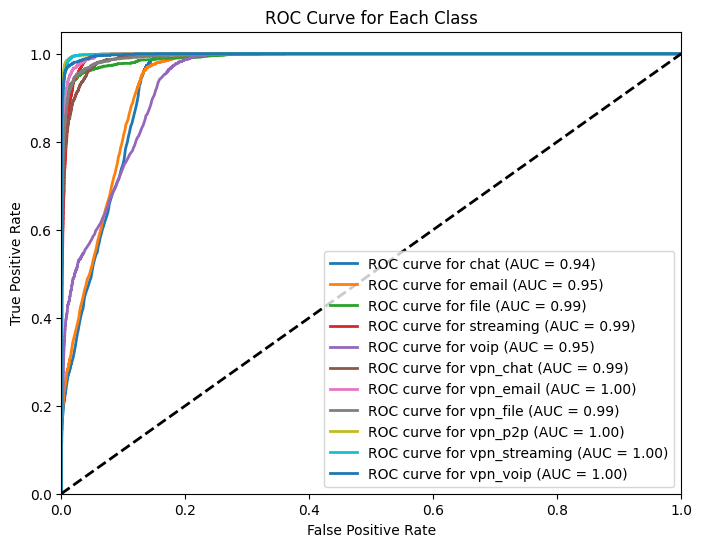

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names_title)):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'AUC for {class_names_title[i]}: {roc_auc[i]:.2f}')

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names_title):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Transfer learning

In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.data import random_split
import random
import torch.utils.data as data
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.Grayscale(num_output_channels=3), # Chuyển đổi thành ảnh xám, 3 kênh màu xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [4]:
dataset_root = "image_dataset/traffics_dataset/"  # Thư mục gốc chứa dataset
train_dataset = ImageFolder(
    root=dataset_root, transform=data_transform)
class_names_title = train_dataset.classes
label_to_class_name = {index: class_name for index,
                       class_name in enumerate(class_names_title)}
label_display = [label_to_class_name[label]
                 for label in range(len(class_names_title))]
print(class_names_title)

['chat', 'email', 'file', 'streaming', 'voip', 'vpn_chat', 'vpn_email', 'vpn_file', 'vpn_p2p', 'vpn_streaming', 'vpn_voip']


In [5]:
batch_size = 512  # Kích thước batch
total_samples = len(train_dataset)

# Chia lượng data được sử dụng
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Lấy datata random theo tỉ lệ
selected_samples = random.sample(range(total_samples), samples_to_use)

# Tạo ra các subset trên mỗi sample
train_dataset = data.Subset(train_dataset, selected_samples)
total_samples = len(train_dataset)

train_size = int(0.7 * total_samples)
validate_size = int(0.15 * total_samples)
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Total 154052
Test Amount 23109
Train Amount 107836
Validation Amount 23107


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


AlexNet

In [35]:
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 11
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [36]:
learning_rate = 0.0001
num_epochs = 200
weight_decay = 0.001

In [37]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        alexnet.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [38]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 10  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [39]:
alexnet.to(device)
for epoch in range(num_epochs):
    alexnet.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    alexnet.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')


    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/200, Train Loss: 1.5600, Train Accuracy: 46.47%, Validation Loss: 1.1073, Validation Accuracy: 59.57%
Epoch 2/200, Train Loss: 1.2191, Train Accuracy: 56.63%, Validation Loss: 0.9777, Validation Accuracy: 62.98%
Epoch 3/200, Train Loss: 1.1225, Train Accuracy: 59.20%, Validation Loss: 0.9220, Validation Accuracy: 64.84%
Epoch 4/200, Train Loss: 1.0707, Train Accuracy: 60.54%, Validation Loss: 0.9023, Validation Accuracy: 65.52%
Epoch 5/200, Train Loss: 1.0314, Train Accuracy: 61.62%, Validation Loss: 0.8761, Validation Accuracy: 65.79%
Epoch 6/200, Train Loss: 1.0096, Train Accuracy: 62.48%, Validation Loss: 0.8483, Validation Accuracy: 66.52%
Epoch 7/200, Train Loss: 0.9862, Train Accuracy: 62.82%, Validation Loss: 0.8366, Validation Accuracy: 67.06%
Epoch 8/200, Train Loss: 0.9697, Train Accuracy: 63.27%, Validation Loss: 0.8288, Validation Accuracy: 67.49%
Epoch 9/200, Train Loss: 0.9555, Train Accuracy: 63.78%, Validation Loss: 0.8192, Validation Accuracy: 66.86%
Epoch 10/2

In [40]:
model_save_path = "GUI/models/traffics_classification_alexnet.pth"
torch.save({
    'model_state_dict': alexnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_alexnet.pth


In [41]:
model_save_path = "GUI/models/traffics_classification_alexnet.pth"
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 11
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
alexnet.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [42]:
alexnet = alexnet.to(device)
alexnet.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = alexnet(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.7201523216063006


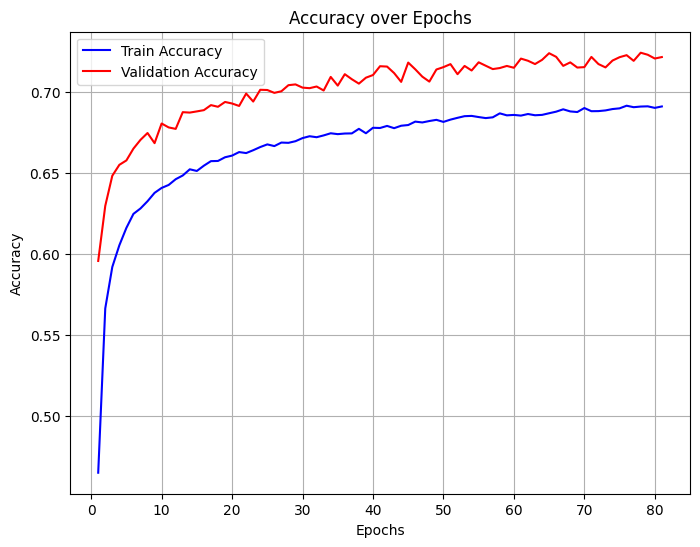

In [43]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

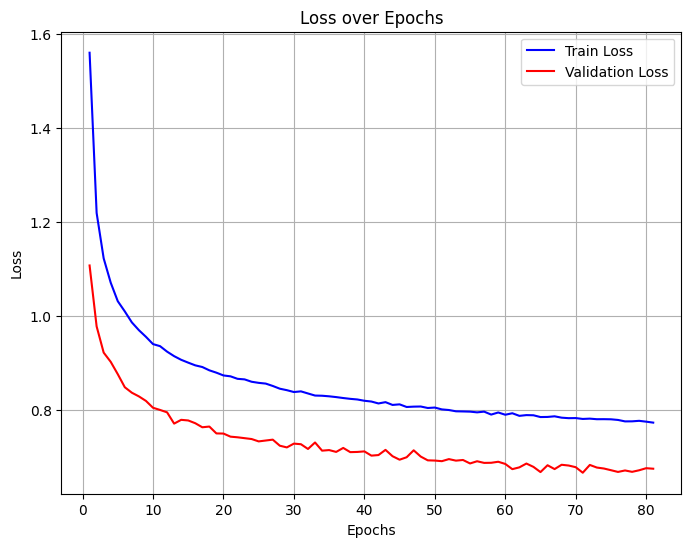

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

AlexNet's Confusion Matrix:


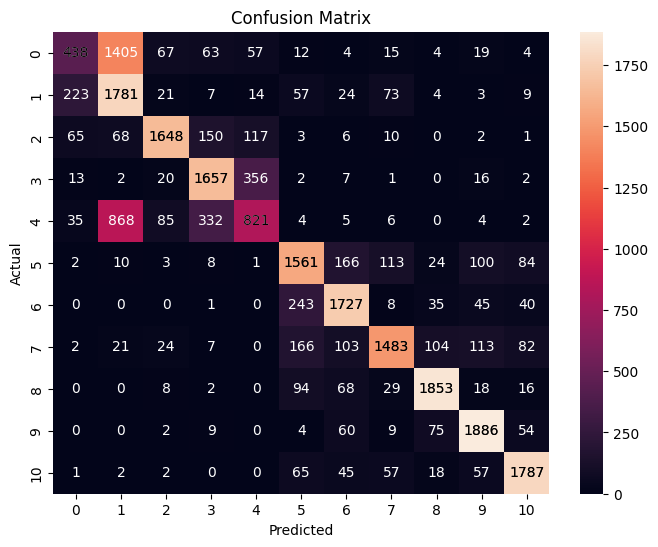

In [45]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("AlexNet's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

alexnet_precision = np.mean(precisions)
alexnet_recall = np.mean(recalls)
alexnet_f1_score = np.mean(f1_scores)
alexnet_acc = predict_accuracy

print("AlexNet's precision", alexnet_precision)
print("AlexNet's recall", alexnet_recall)
print("AlexNet's f1-score",alexnet_f1_score)
print(f"AlexNet's Accuracy: {alexnet_acc}")

AlexNet's precision 0.7349595253487876
AlexNet's recall 0.7211563717400687
AlexNet's f1-score 0.7123464302809018
AlexNet's Accuracy: 0.7201523216063006


VGG-16

In [17]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 11
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [9]:
learning_rate = 0.0001
num_epochs = 60
weight_decay = 0.0001

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        vgg16.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [20]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [52]:
vgg16.to(device)
for epoch in range(num_epochs):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/60, Train Loss: 1.2935, Train Accuracy: 53.31%, Validation Loss: 0.8959, Validation Accuracy: 65.47%
Epoch 2/60, Train Loss: 0.9325, Train Accuracy: 64.85%, Validation Loss: 0.7825, Validation Accuracy: 69.39%
Epoch 3/60, Train Loss: 0.8387, Train Accuracy: 67.35%, Validation Loss: 0.7433, Validation Accuracy: 70.25%
Epoch 4/60, Train Loss: 0.7908, Train Accuracy: 68.84%, Validation Loss: 0.6941, Validation Accuracy: 71.55%
Epoch 5/60, Train Loss: 0.7521, Train Accuracy: 70.03%, Validation Loss: 0.6768, Validation Accuracy: 72.00%
Epoch 6/60, Train Loss: 0.7296, Train Accuracy: 70.82%, Validation Loss: 0.6489, Validation Accuracy: 72.95%
Epoch 7/60, Train Loss: 0.7102, Train Accuracy: 71.30%, Validation Loss: 0.6390, Validation Accuracy: 73.61%
Epoch 8/60, Train Loss: 0.6939, Train Accuracy: 71.85%, Validation Loss: 0.6254, Validation Accuracy: 73.37%
Epoch 9/60, Train Loss: 0.6791, Train Accuracy: 72.19%, Validation Loss: 0.6208, Validation Accuracy: 73.70%
Epoch 10/60, Train 

KeyboardInterrupt: 

In [53]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_vgg16.pth


In [21]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 11
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Train bổ sung khi ngắt train trước

In [22]:
vgg16.to(device)
for epoch in range(46, 60):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 47/60, Train Loss: 0.5379, Train Accuracy: 77.07%, Validation Loss: 0.4728, Validation Accuracy: 79.02%
Epoch 48/60, Train Loss: 0.5383, Train Accuracy: 77.21%, Validation Loss: 0.4740, Validation Accuracy: 79.02%
Epoch 49/60, Train Loss: 0.5368, Train Accuracy: 77.12%, Validation Loss: 0.4760, Validation Accuracy: 79.02%
Epoch 50/60, Train Loss: 0.5361, Train Accuracy: 77.19%, Validation Loss: 0.4731, Validation Accuracy: 79.02%
Epoch 51/60, Train Loss: 0.5388, Train Accuracy: 77.24%, Validation Loss: 0.4724, Validation Accuracy: 79.02%
Epoch 52/60, Train Loss: 0.5361, Train Accuracy: 77.24%, Validation Loss: 0.4749, Validation Accuracy: 79.02%
Epoch 53/60, Train Loss: 0.5364, Train Accuracy: 77.16%, Validation Loss: 0.4713, Validation Accuracy: 79.02%
Epoch 54/60, Train Loss: 0.5363, Train Accuracy: 77.28%, Validation Loss: 0.4768, Validation Accuracy: 79.02%
Epoch 55/60, Train Loss: 0.5363, Train Accuracy: 77.12%, Validation Loss: 0.4724, Validation Accuracy: 79.02%
Epoch 56/6

In [23]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/traffics_classification_vgg16.pth


In [11]:
model_save_path = "GUI/models/traffics_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 11
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [12]:
vgg16 = vgg16.to(device)
vgg16.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = vgg16(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.793586914189277


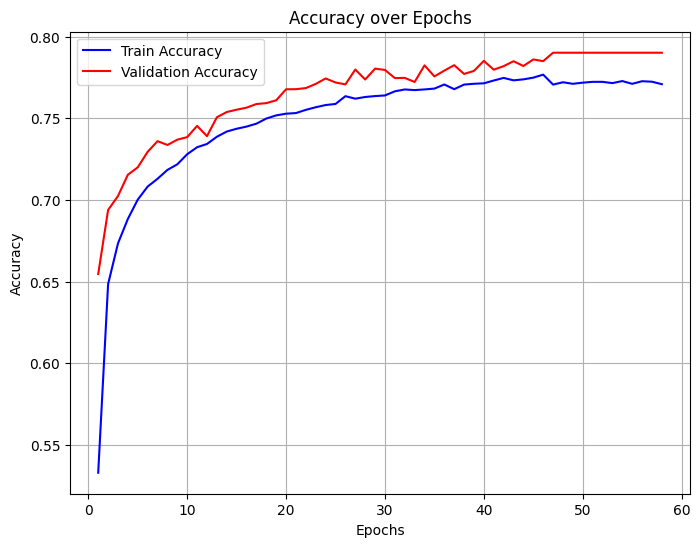

In [13]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

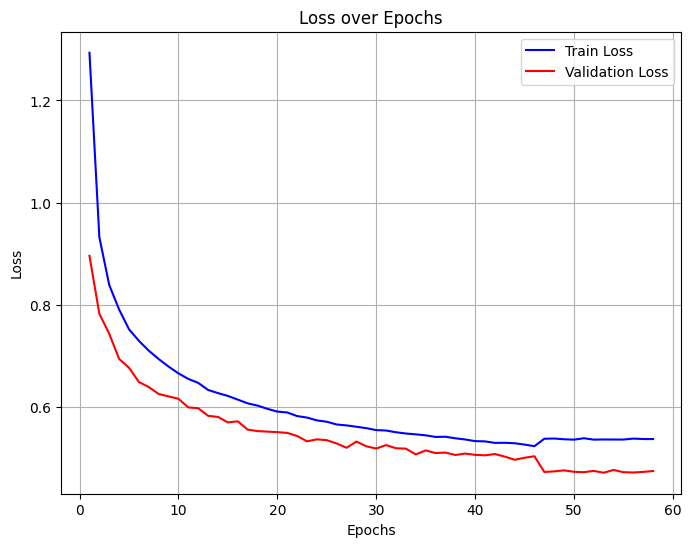

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

VGG-16's Confusion Matrix:


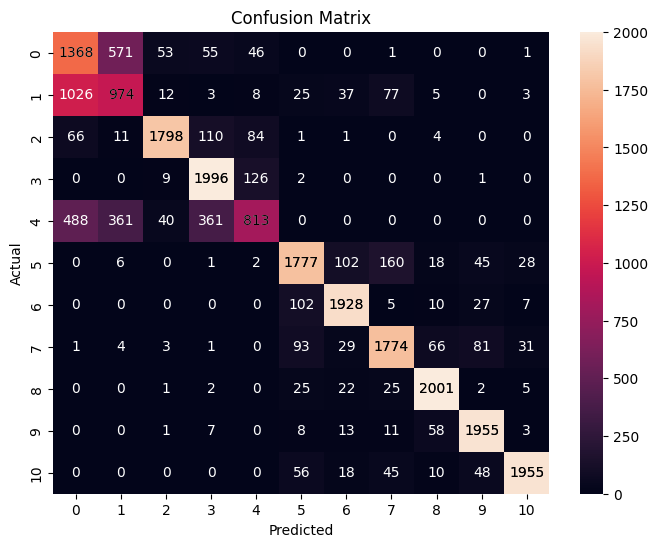

In [15]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("VGG-16's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

vgg16_precision = np.mean(precisions)
vgg16_recall = np.mean(recalls)
vgg16_f1_score = np.mean(f1_scores)
vgg16_acc = predict_accuracy

print("VGG-16's precision", vgg16_precision)
print("VGG-16's recall", vgg16_recall)
print("VGG-16's f1-score",vgg16_f1_score)
print(f"VGG-16's Accuracy: {vgg16_acc}")

VGG-16's precision 0.8026521538132669
VGG-16's recall 0.7941847286494201
VGG-16's f1-score 0.7908148325942302
VGG-16's Accuracy: 0.793586914189277
